In [ ]:
# !pip install 'h5py==2.10.0' --force-reinstall

# Gradient-weighted Class Activation Mapping (Grad-CAM)

- Train a CNN model to understand cats & dogs
- Make predictions on unseen images
- Visualze and interpret model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [ ]:
import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [ ]:
dataset_path = '/content/drive/MyDrive/dog vs cat/dataset'

## Read and load images to ImageDataGenerator

In [ ]:
BATCH_SIZE = 16
IMG_WIDTH = 224
IMG_HEIGHT = 224

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        dataset_path + '/training_set',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        dataset_path + '/test_set',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical')


Found 8074 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


## Define Model

In [ ]:
def create_model(summary=True):
    # apply transfer learning
    new_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    model = ResNet50(weights='imagenet', include_top=False, input_tensor=new_input)
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    output = Dense(2, activation='softmax')(flat1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    if summary:
        print(model.summary())
    return model

In [ ]:
model_dir = '/content/drive/MyDrive/dog vs cat/model'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

checkpoint_path = model_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
model = create_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Training a model

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=100,
        callbacks=[cp_callback])


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.9000
Epoch 1: saving model to /content/drive/MyDrive/dog vs cat/model/cp.ckpt
100/100 [==============================] - 519s 5s/step - loss: 0.4158 - accuracy: 0.9000 - val_loss: 2.9305 - val_accuracy: 0.5044
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9504
Epoch 2: saving model to /content/drive/MyDrive/dog vs cat/model/cp.ckpt
100/100 [==============================] - 135s 1s/step - loss: 0.1996 - accuracy: 0.9504 - val_loss: 1.4888 - val_accuracy: 0.5069
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9513
Epoch 3: saving model to /content/drive/MyDrive/dog vs cat/model/cp.ckpt
100/100 [==============================] - 67s 671ms/step - loss: 0.2101 - accuracy: 0.9513 - val_loss: 0.9336 - val_accuracy: 0.5050
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9631

## Model Metrics

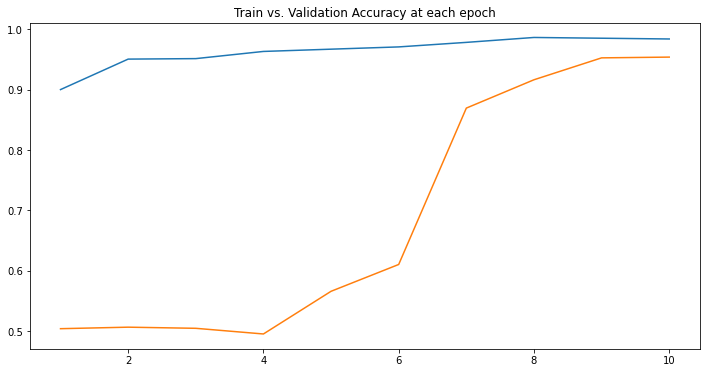

In [ ]:
# show history
history_df = pd.DataFrame(history.history)
epochs = list(range(1, 11))

plt.figure(figsize=(12, 6))
plt.plot(epochs, history_df['accuracy'].values)
plt.plot(epochs, history_df['val_accuracy'].values)
plt.title('Train vs. Validation Accuracy at each epoch')
plt.show()

## Load from checkpoint

In [ ]:
# load model
latest = tf.train.latest_checkpoint(checkpoint_dir)

# Create a new model instance
loaded_model = create_model(summary=True)

# Load the previously saved weights
loaded_model.load_weights(latest)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Make a prediction

In [ ]:
def make_prediction():
    val_path = dataset_path + '/test_set'

    dog_or_cat = np.random.randint(1, 3)

    folder = None

    if dog_or_cat == 1:
        print('ACTUAL LABEL: CAT')
        folder = val_path + '/cats'    
    else:
        print('ACTUAL LABEL: DOG')
        folder = val_path + '/dogs'

    img_paths = os.listdir(folder)
    folder_size = len(img_paths)
    idx = np.random.randint(0, folder_size)
    img = cv2.imread(folder + '/' + img_paths[idx], )
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    rescaled_img = img/255.0
    plt.imshow(rescaled_img)
    batch_pred = np.expand_dims(rescaled_img, 0)
    pred = np.argmax(loaded_model.predict(batch_pred)[0])
    if pred == 0:
        print('PRED LABEL: CAT')
    else:
        print('PRED LABEL: DOG')
    return pred

ACTUAL LABEL: CAT
PRED LABEL: CAT


0

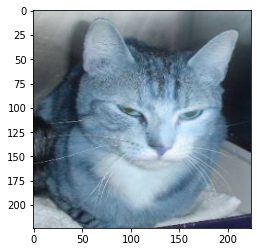

In [ ]:
# Example: cat
make_prediction()

ACTUAL LABEL: DOG
PRED LABEL: DOG


1

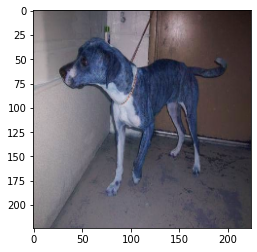

In [ ]:
# Example: dog
make_prediction()

## Model Visualization 

In [ ]:
def show_img(img_array, title):
    plt.title(title)
    plt.imshow(img_array)
    plt.show()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    # Remove last layer's softmax
    model.layers[-1].activation = None

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    show_img(superimposed_img, 'IMAGE OUT: Grad-CAM')


# make a prediction and visualize grad-cam
def make_prediction_and_visualize():
    val_path = dataset_path + '/test_set'

    dog_or_cat = np.random.randint(1, 3)

    folder = None

    if dog_or_cat == 1:
        print('ACTUAL LABEL: CAT')
        folder = val_path + '/cats'    
    else:
        print('ACTUAL LABEL: DOG')
        folder = val_path + '/dogs'

    img_paths = os.listdir(folder)
    folder_size = len(img_paths)
    idx = np.random.randint(0, folder_size)
    img_path = folder + '/' + img_paths[idx]
    img = cv2.imread(img_path)
    show_img(img, 'IMAGE OUT: ACTUAL')
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)
    pred = np.argmax(loaded_model.predict(batch_pred)[0])
    
    if pred == 0:
        print('PRED LABEL: CAT')
    else:
        print('PRED LABEL: DOG')

    last_conv_layer_name = 'conv5_block3_3_conv'

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_gradcam(img_path, heatmap)
    return pred


ACTUAL LABEL: CAT


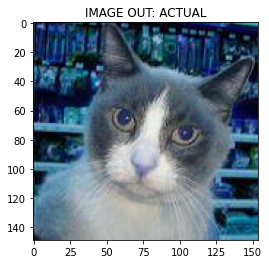

PRED LABEL: CAT


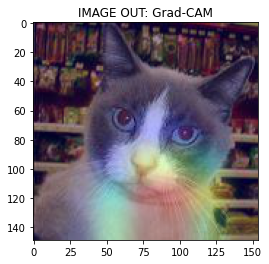

0

In [ ]:
# Example: cat
make_prediction_and_visualize()

ACTUAL LABEL: DOG


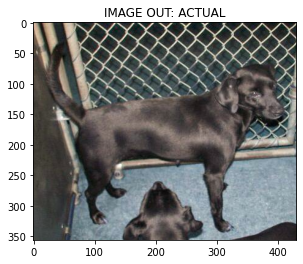

PRED LABEL: DOG


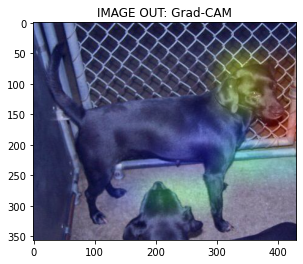

1

In [ ]:
# Example: dog
make_prediction_and_visualize()